# Data Visualization
In this notebook, we will explore the dataset generated using [generate_sionna_dataset.py](../scripts/generate_datasets_from_sionna.py)

In [1]:
# Imports

import os
from typing import Optional

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from cebed.utils import read_metadata
from cebed.datasets.utils import read_dataset_from_file

os.environ["CUDA_VISIBLE_DEVICES"]=""

2023-05-17 14:50:48.731268: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-17 14:50:49.613388: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/user/amal.feriani/anaconda3/envs/tf/lib/
2023-05-17 14:50:49.613497: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/user/amal.feriani/anaconda3/envs/tf/lib/
2023-05-17 14:50:49.613507: W tensorflow/com

In [2]:
data_path = "../tests/data/siso_data_md/"
assert os.path.isdir(data_path)

In [3]:
# Read data
data = read_dataset_from_file(os.path.join(data_path, "data.hdf5"))
env_config = read_metadata(os.path.join(data_path, "metadata.yaml"))

In [4]:
# Investigate data

print(f"Available data {data.keys()}")

print(f"Channels : {data['h'].shape}") # expected shape [num_domains, size, nrof_receivers, nrof_receive_antennas, nrof_transmitters, nrof_transmitter_streams, nrof_ofdm_symbols, nrof_ofdm_subcarriers]
print(f"Number of domains: {len(data['h'])}")

Available data <KeysViewHDF5 ['h', 'x', 'y']>
Channels : (5, 100, 1, 1, 1, 1, 14, 72)
Number of domains: 5


In [12]:

# Utility function to plot random channels from dataset
def display_complex_channels(tensors:tf.Tensor, sample_size:int=5, mask:Optional[tf.Tensor]=None)->plt.figure:
    
    figure = plt.figure(figsize=(10, 10))
        
    if len(tensors.shape) < 4:
        # add spatial dim if missing
        tensors = tf.expand_dims(tensors, 1)

    ids = np.random.choice(len(tensors), size=sample_size, replace=False)

    if isinstance(mask, tf.Tensor):
        mask = mask.numpy()
        
    for i, idx in enumerate(ids):            
        plt.subplot(sample_size, 2, 2 * i + 1)
        sns.heatmap(tf.math.real(tensors[idx, 0]), mask=mask)
        plt.subplot(sample_size, 2, 2 * i + 2)
        sns.heatmap(tf.math.imag(tensors[idx, 0]), mask=mask)

    return figure

Let's visualize the channels of a given train domain

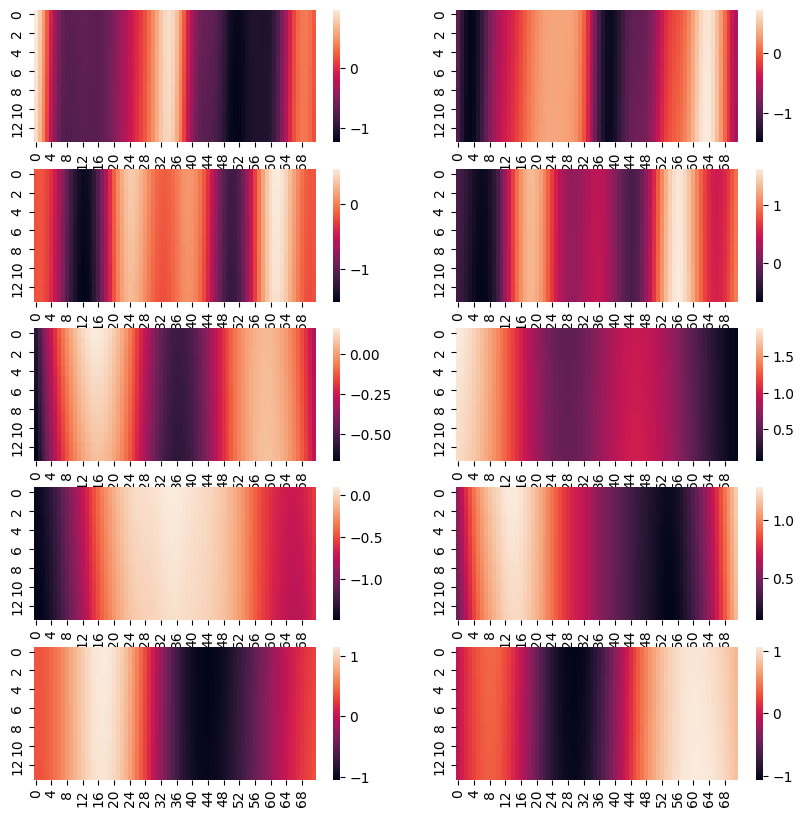

In [13]:
domain_id = 0
figure = display_complex_channels(tf.squeeze(data['h'])[domain_id])
plt.show()

## Investigate the environment

In [7]:
from cebed.envs import OfdmEnv
from pprint import pprint

env = OfdmEnv(env_config)
pprint(vars(env_config))

{'carrier_frequency': 2100000000.0,
 'direction': 'uplink',
 'dynamic_topology': True,
 'fft_size': 72,
 'los': False,
 'n_ues': 1,
 'normalize_channel': True,
 'num_bits_per_symbol': 2,
 'num_ofdm_symbols': 14,
 'num_rx_antennas': 1,
 'num_streams_per_tx': 1,
 'p_spacing': 1,
 'path_loss': True,
 'pilot_ofdm_symbol_indices': [3, 10],
 'pilot_pattern': 'block',
 'scenario': 'umi',
 'seed': 0,
 'shadowing': True,
 'subcarrier_spacing': 30000.0,
 'ue_speed': 5}


[<Figure size 640x480 with 2 Axes>]

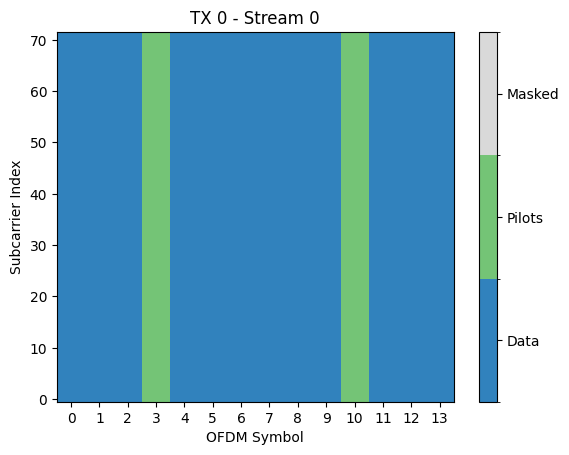

In [8]:
# Visualize the pilot pattern
env.rg.pilot_pattern.show()


### Extract LS estimates (model inputs)

In [9]:
received_signals = np.array(data['y'][:])
inputs = env.estimate_at_pilot_locations(received_signals[domain_id])

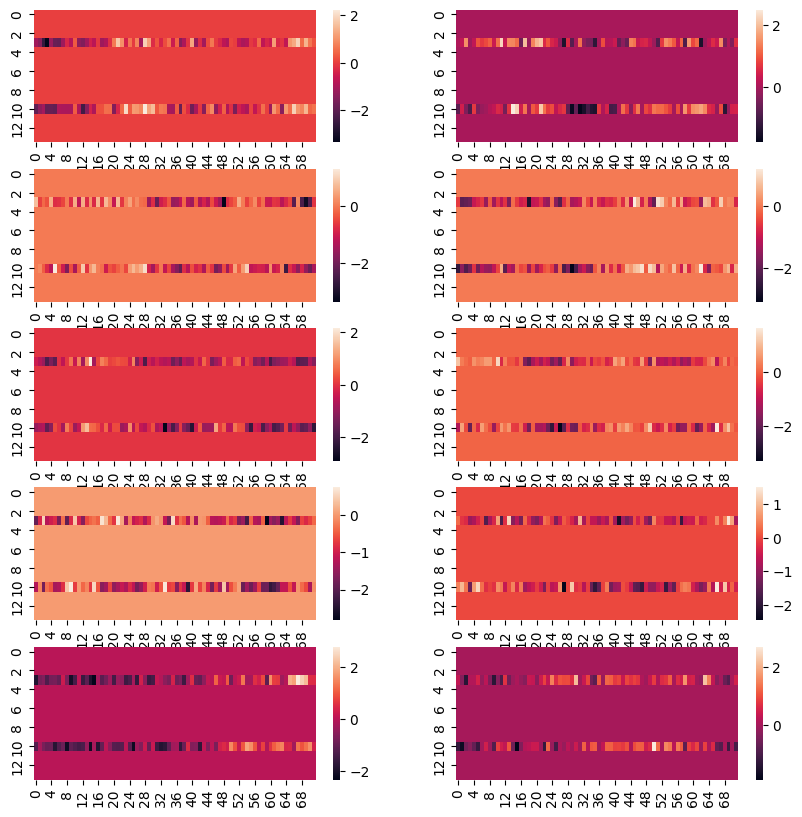

In [10]:
mask = tf.squeeze(env.rg.pilot_pattern.mask)

figure = display_complex_channels(tf.squeeze(inputs), mask=mask)
plt.show()